# ANES


[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_gap.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [3]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [5]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

## Read the Data

I'm using data I previous cleaned in [this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/01_make_pacs_extract.ipynb).

In [6]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [7]:
# download("https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_pacs_2022.hdf")

In [8]:
df = pd.read_stata('anes_timeseries_cdf_stata_20220916.dta', convert_categoricals=False)
df.shape

(68224, 1030)

In [9]:
column_dict = {'VCF0004': 'year',
               'VCF0803': 'polviews',
               'VCF0301': 'partyid',
               'VCF0302': 'partyid3',
               'VCF0104': 'sex',
               'VCF0101': 'age',
               'VCF0009z': 'wtsamp'}

df.rename(columns=column_dict, inplace=True)

In [10]:
recode_polviews = {
    1: "Liberal",
    2: "Moderate",
    3: "Conservative",
}
df["polviews3"] = df["VCF0804"].replace(recode_polviews)
df["polviews3"].value_counts()

/tmp/ipykernel_202514/1324274489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["polviews3"] = df["VCF0804"].replace(recode_polviews)


polviews3
Conservative    15631
Moderate        12532
Liberal         10984
9.0              9568
0.0              4193
Name: count, dtype: int64

In [11]:
df['wtsamp'].describe()

count    68224.000000
mean         1.039790
std          0.564906
min          0.021200
25%          0.896200
50%          1.000000
75%          1.000000
max          6.932929
Name: wtsamp, dtype: float64

In [12]:
values(df['year'])

year
1948.0     662
1952.0    1899
1954.0    1139
1956.0    1762
1958.0    1450
1960.0    1181
1962.0    1297
1964.0    1571
1966.0    1291
1968.0    1557
1970.0    1507
1972.0    2705
1974.0    1575
1976.0    2248
1978.0    2304
1980.0    1614
1982.0    1418
1984.0    2257
1986.0    2176
1988.0    2040
1990.0    1980
1992.0    2485
1994.0    1795
1996.0    1714
1998.0    1281
2000.0    1807
2002.0    1511
2004.0    1212
2008.0    2322
2012.0    5914
2016.0    4270
2020.0    8280
Name: count, dtype: int64

The primary variable we'll use is [polviews](https://subsetdataexplorer.norc.org/variables/178/vshow), which asks

> We hear a lot of talk these days about liberals and conservatives. I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The points on the scale are Extremely liberal, Liberal, and Slightly liberal; Moderate;	Slightly conservative, Conservative, and Extremely conservative.

In [13]:
values(df['sex'])

sex
0.0      211
1.0    30612
2.0    37390
3.0       11
Name: count, dtype: int64

In [14]:
values(df['age'])

age
0.0      887
17.0      21
18.0     498
19.0     605
20.0     690
        ... 
96.0       3
97.0       2
98.0       2
99.0       4
NaN     1801
Name: count, Length: 85, dtype: int64

In [15]:
df['age'].replace(0, np.nan, inplace=True)

In [16]:
values(df['polviews'])

polviews
0.0     2400
1.0     1229
2.0     4821
3.0     4934
4.0    12532
5.0     6567
6.0     7523
7.0     1541
9.0    11361
NaN    15316
Name: count, dtype: int64

In [17]:
values(df['VCF0804'])

VCF0804
0.0     4193
1.0    10984
2.0    12532
3.0    15631
9.0     9568
NaN    15316
Name: count, dtype: int64

In [18]:
values(df['partyid3'])

partyid3
1.0    14125
2.0    15856
3.0     2937
4.0      733
5.0    20437
8.0      133
9.0      244
NaN    13759
Name: count, dtype: int64

In [19]:
def make_diff(df):
    """Compute % liberal minus % conservative.
    """
    year = df["year"]
    column = df["polviews3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab['Liberal'] - xtab['Conservative']
    
    return diff * 100

In [20]:
def make_mean(df):
    """Compute % liberal minus % conservative.
    """
    series = df.groupby('year')['polviews'].mean()
    
    return series

In [21]:
def decorate_plot(title):
    decorate(xlabel='Year',
             ylabel='% liberal - % conservative',
             title=title)

## Make the plot with all respondents

The following functions generate a figure like the one in the FT.

In [22]:
def make_plot(df, title=''):
    """Plot % liberal - % conservative for male and female respondents.
    """
    male = df.query('sex==1')
    female = df.query('sex==2')

    diff_male = make_diff(male)
    diff_female = make_diff(female)

    plot_series_lowess(diff_male, color='C0', label='Male')
    plot_series_lowess(diff_female, color='C1', label='Female')
    decorate_plot(title)

Generate the plot for all respondents.

In [23]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

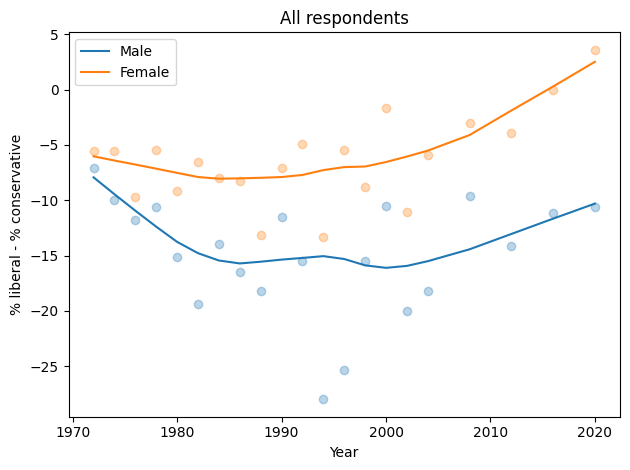

In [24]:
make_plot(df, 'All respondents')
savefig('anes_gap1.png')

In the general population, men are more likely to say they are conservative by 5-10 percentage points. 

The gap might have increased in the most recent data, depending on how seriously we take the last two points in a noisy series.

## Just young people

Now let's select just people under 30.

In [25]:
subset = df.query('age < 30')
subset.shape

(12297, 1031)

And make the same figure.

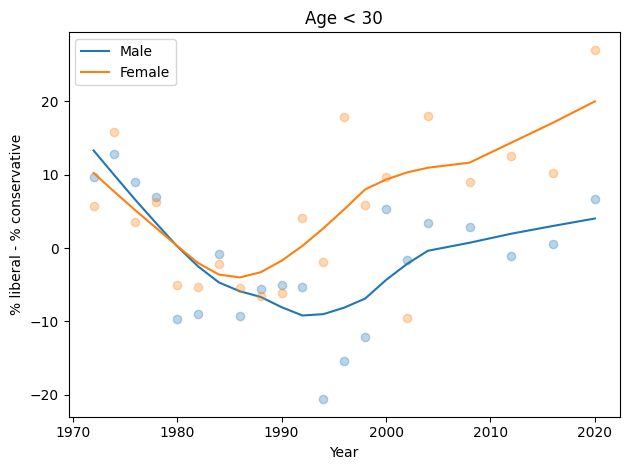

In [26]:
make_plot(subset, 'Age < 30')
savefig('anes_gap2.png')

The trends here are pretty much the same as in the general population.
Men are more likely to say they are conservative, by 5-10 percentage points.

It's possible that the gap has grown in the most recent data, but the evidence is weak and depends on how we draw a smooth curve through noisy data.

Anyway, there is no evidence the trend for men is going down, and the gap in the most recent data is nowhere near 30 percentage points.

Here are the sample sizes.

In [27]:
year = subset["year"]
column = subset["sex"]
xtab = pd.crosstab(column, year)
xtab

year,1952.0,1956.0,1958.0,1960.0,1962.0,1964.0,1966.0,1968.0,1970.0,1972.0,...,1994.0,1996.0,1998.0,2000.0,2002.0,2004.0,2008.0,2012.0,2016.0,2020.0
sex,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1.0,143,119,72,39,91,128,105,123,120,339,...,160,110,124,114,63,117,177,443,324,459
2.0,177,186,116,67,110,162,131,163,194,405,...,162,145,118,165,84,122,233,493,323,540
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


## With Sampling Weights

In the previous figures, I have not taken into account the sampling weights.
I didn't expect them to make much difference, and they don't except for men in 2022 -- and as we'll see, there is almost certainly something wrong with that data point.

In [28]:
male = subset.query('sex==1')
female = subset.query('sex==2')

diff_male = make_diff(male)
diff_female = make_diff(female)

We only have weighted data since 1988, since that's how far back the `wtsamp` variable goes.



In [93]:
recent = df.dropna(subset=['wtsamp']).query('age < 30').copy()

In [94]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [95]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [96]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [97]:
def plot_percentiles(series_seq, ps=None, label=None, **options):
    """Plot the low, median, and high percentiles.

    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    assert len(ps) == 3

    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

## Resampling and smoothing

In [98]:
def resample_diffs_smooth(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtsamp").query(query)
        diff = make_diff(sample)
        smooth = make_lowess(diff)
        diffs.append(smooth)
    return diffs

In [99]:
diffs_male = resample_diffs_smooth(recent, 'sex==1')
diffs_female = resample_diffs_smooth(recent, 'sex==2')

Here's a version of the same plot with moderate smoothing, and dropping the unweighted data.

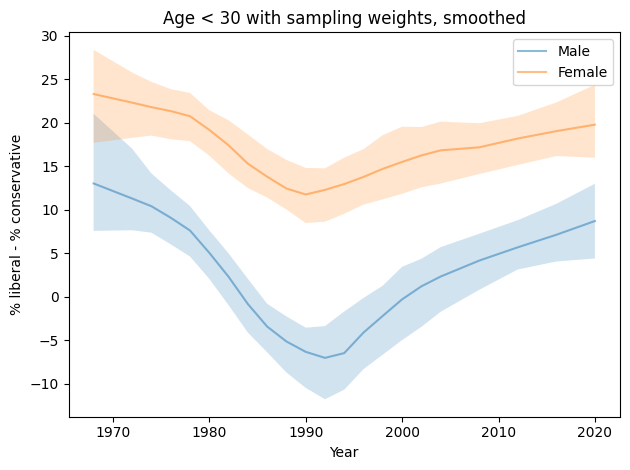

In [100]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed')
savefig('anes_gap4.png')

You could make the argument that this figure shows evidence for an increasing gap, but the error bounds are very wide, and as we'll see in the next figure, the entire effect is due to the likely error in the 2022 data.

## Party Affiliation

In [101]:
def make_diff(df):
    """Compute % Democrat minus % Republican.
    """
    year = df["year"]
    column = df["partyid3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab[5] - xtab[1]
    
    return diff * 100

In [102]:
diffs_male = resample_diffs_smooth(recent, 'sex==1')
diffs_female = resample_diffs_smooth(recent, 'sex==2')

Here's a version of the same plot with moderate smoothing, and dropping the unweighted data.

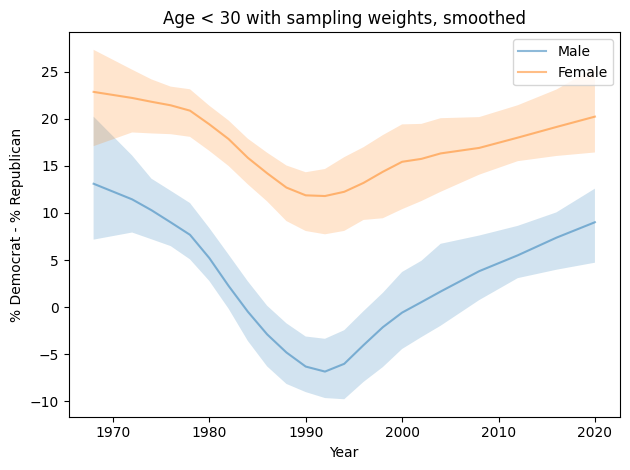

In [103]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed')
plt.ylabel('% Democrat - % Republican')

savefig('anes_gap4.png')

In [104]:
def kl_divergence():
    combined_index = pmf1.index.union(pmf2.index)
    pmf1 = pmf1.reindex(combined_index, fill_value=0)
    pmf2 = pmf2.reindex(combined_index, fill_value=0)

    return np.sum(pmf1 * np.log(pmf1 / pmf2))

In [105]:
recent = df.query('year >= 1972')

In [106]:
df_con = recent.query('polviews3 == "Conservative"')
df_lib = recent.query('polviews3 == "Liberal"')

In [107]:
def compute_diff(col):
    con = df_con[col].dropna().value_counts()
    if len(con) == 0:
        return np.nan
    lib = df_lib[col].dropna().value_counts()
    value = con.idxmax()
    p_con = con[value] / con.sum()
    p_lib = lib.get(value, np.nan) / lib.sum()
    return abs(p_con - p_lib)

In [108]:
res = []
for col in recent.columns:
    diff = compute_diff(col)
    res.append((col, diff))

In [109]:
candidates = pd.DataFrame(res).dropna().sort_values(by=1, ascending=False).head(200).tail(101)
candidates

,0,1
233,VCF0380,0.225842
816,VCF9008,0.225359
622,VCF0877,0.224601
583,VCF0834,0.222707
256,VCF0387b,0.222621
...,...,...
289,VCF0396b,0.122479
765,VCF1020,0.122057
176,VCF0338,0.121605
579,VCF0829,0.120603


In [110]:
string_to_empty_dict = {key: '' for key in candidates[0]}

In [111]:
candidate_dict = {
 'VCF0849': 'lib or con',
 'VCF0303': 'partyid',
 'VCF0713': 'voting intent',
 'VCF9204': 'which party',
 'VCF0704': 'vote',
 'VCF0705': 'vote',
 'VCF0704a': 'vote',
 'VCF0706': 'vote',
 'VCF9205': 'party',
 'VCF9027': '',
 'VCF0487': '',
 'VCF9209': '',
 'VCF0475': '',
 'VCF9212': '',
 'VCF0372': '',
 'VCF0360': '',
 'partyid3': '',
 'VCF9210': '',
 'VCF0734': '',
 'VCF9131': 'LESS GOVERNMENT BETTER OR GOVERNMENT DO MORE',
 'VCF0709': '',
 'VCF0386': '',
 'VCF0373': '',
 'VCF0894': 'FEDERAL SPENDING- WELFARE PROGRAMS',
 'VCF0481': '',
 'VCF0361': '',
 'VCF0700': '',
 'VCF0374': '',
 'VCF0493': '',
 'VCF0707': '',
 'VCF0736': '',
 'VCF9133': 'GOVT TOO INVOLVED IN THINGS OR PROBLEMS REQUIRE',
 'VCF0876a': 'LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION',
 'VCF9238': 'SHOULD THE GOVERNMENT MAKE IT MORE DIFFICULT OR EASIER TO BUY A GUN, OR SHOULD THE RULES STAY THE SAME AS THEY ARE NOW',
 'VCF0385b': '',
 'VCF0401': '',
 'VCF0370': '',
 
 'VCF0371': '',
 'VCF0853': 'SHOULD BE MORE EMPHASIS ON TRADITIONAL VALUES',
 'VCF0878': 'SHOULD GAYS/LESBIANS BE ABLE TO ADOPT CHILDREN',
 'VCF9228': 'MUCH OR SOMEWHAT LARGER/SMALLER GAP IN INCOMES BETWEEN RICH AND POOR IN THE U.S. THAN 20 YEARS AGO',
 'VCF0867a': 'AFFIRMATIVE ACTION IN HIRING/PROMOTION',
 'VCF0405': '',
 'VCF0359': '',
 'VCF9085': '',
 'VCF9132': 'GOVT HANDLE ECONOMY OR FREE MARKET CAN HANDLE',
 'VCF0877a': 'POSITION ON GAYS IN THE MILITARY',
 'VCF9237': 'STRENGTH FAVOR/OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER',
 'VCF9236': 'FAVOR OR OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER',
 'VCF9207': '',
 'VCF9275': 'IN AMERICAN POLITICS, DO BLACKS HAVE TOO MUCH, ABOUT THE RIGHT AMOUNT OF, OR TOO LITTLE INFLUENCE',
 'partyid': '',
 'VCF0890': 'FEDERAL SPENDING- PUBLIC SCHOOLS',
 'VCF9219': '',
 'VCF0358': '',
 'VCF1043b': '',
 'VCF9086': '',
 'VCF9213': '',
 'VCF0369': '',
 'VCF9211': '',
 'VCF9088': '',
 'VCF0833': 'FAVOR OR OPPOSE EQUAL RIGHTS AMENDMENT',
 'VCF0406': '',
 'VCF0601': 'APPROVE PARTICIPATION IN PROTESTS',
 'VCF0851': 'NEWER LIFESTYLES CONTRIBUTE TO SOCIETY BREAKDOWN',
 'VCF0852': 'SHOULD ADJUST VIEW OF MORAL BEHAVIOR TO CHANGES',
 'VCF0867': 'AFFIRMATIVE ACTION IN HIRING/PROMOTION',
 'VCF0893': 'FEDERAL SPENDING- THE HOMELESS',
 'VCF0846': 'IS RELIGION IMPORTANT TO RESPONDENT',
 'VCF9241': '',
 'VCF1004': '',
 'VCF0738': '',
 'VCF0392': '',
 'VCF9215': '',
 'VCF0879a': 'INCREASE OR DECREASE NUMBER OF IMMIGRANTS TO U.S. 4-CATEGORY',
 'VCF0889': 'FEDERAL SPENDING- AIDS RESEARCH/FIGHT AIDS',
 'VCF9028': '',
 'VCF0876': 'LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION',
 'VCF9216': '',
 'VCF9249': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: INDEPENDENCE OR RESPECT FOR ELDERS',
 'VCF0828': 'SHOULD GOVERNMENT CUT MILITARY SPENDING',
 'VCF0838': 'WHEN SHOULD ABORTION BE ALLOWED',
 'VCF9247': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: OBEDIENCE OR SELF-RELIANCE',
 'VCF1042b': '',
 'VCF9227': 'DOES R THINK THE DIFFERENCE IN INCOMES BETWEEN RICH AND POOR IN THE U.S. IS LARGER, SMALLER, OR ABOUT THE SAME AS 20 YEARS AGO',
 'VCF9040': 'BLACKS SHOULD NOT HAVE SPECIAL FAVORS TO SUCCEED',
 'VCF0424': '',
 'VCF9246': 'WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: CURIOSITY OR GOOD MANNERS',
 'VCF0318': '',
 'VCF0826': 'DID U.S. DO RIGHT THING GETTING INVOLVED IN WAR (DIFFERENT WARS)',
 'VCF9047': 'FEDERAL SPENDING- IMPROVE AND PROTECT THE ENVIRONMENT',
 'VCF9046': 'FEDERAL SPENDING- FOOD STAMPS',
 'VCF0391b': '',
 'VCF0603': 'APPROVE DEMONSTRATIONS',
 'VCF0602': 'APPROVE CIVIL DISOBEDIENCE',
 'VCF0314': '',
 'VCF0808': 'GUARANTEED JOBS AND INCOME',
 'VCF9214': '',
 'VCF9084': '',
 'VCF0380': '',
 'VCF9008': '',
 'VCF0877': 'FAVOR OR OPPOSE GAYS IN THE MILITARY',
 'VCF0834': 'WOMEN EQUAL ROLE SCALE',
 'VCF0387b': '',
 'VCF0866': '',
 'VCF9201': '',
 'VCF0817': 'SCHOOL BUSING SCALE',
 'VCF9013': 'SOCIETY ENSURE EQUAL OPPORTUNITY TO SUCCEED',
 'VCF0738a': '',
 'VCF0402': '',
 'VCF9232': 'FAVOR OR OPPOSE THE U.S. GOVERNMENT TORTURING PEOPLE WHO ARE SUSPECTED OF BEING TERRORISTS, TO TRY TO GET INFORMATION',
 'VCF0128': '',
 'VCF0425': '',
 'VCF9037': 'GOVERNMENT SHOULD ENSURE FAIR JOBS FOR BLACKS',
 'VCF0363': '',
 'VCF9042': 'BLACKS GOTTEN LESS THAN THEY DESERVE OVER THE PAST FEW YEARS',
 'VCF0365': '',
 'VCF9077': 'PRESIDENT ON GOVERNMENT HEALTH INSURANCE SCALE',
 'VCF0215': 'THERMOMETER',
 'VCF0471': '',
 'VCF0235': '',
 'VCF9051': 'SCHOOL PRAYER ALLOWED 2-CATEGORY',
 'VCF0847': 'HOW MUCH GUIDANCE FROM RELIGION',
 'VCF9017': 'SHOULD WORRY LESS ABOUT HOW EQUAL PEOPLE ARE',
 'VCF1037b': '',
 'VCF0806': 'GOVERNMENT HEALTH INSURANCE SCALE',
 'VCF0426': '',
 'VCF0357': '',
 'VCF0130': '',
 'VCF0711': '',
 'VCF0886': 'FEDERAL SPENDING- POOR/POOR PEOPLE',
 'VCF9280': '',
 'VCF0442': '',
 'VCF9221': '',
 'VCF0387a': '',
 'VCF0815': 'SEGREGATION OR DESEGREGATION',
 'VCF0837': 'WHEN SHOULD ABORTION BE ALLOWED',
 'VCF0809': 'GUARANTEED JOBS AND INCOME SCALE',
 'VCF0147': '',
 'VCF0212': '',
 'VCF1030b': '',
 'VCF0447': '',
 'VCF9235': '',
 'VCF9202': '',
 'VCF9041': 'BLACKS MUST TRY HARDER TO SUCCEED',
 'VCF9014': 'WE HAVE GONE TOO FAR PUSHING EQUAL RIGHTS',
 'VCF0381b': '',
 'VCF0830': 'AID TO BLACKS SCALE',
 'VCF0443': '',
 'VCF0440': '',
 'VCF0816': 'SHOULD GOVERNMENT ENSURE SCHOOL INTEGRATION',
 'VCF0319': '',
 'VCF9087': '',
 'VCF0146': '',
 'VCF0218': '',
 'VCF0356': '',
 'VCF1038': '',
 'VCF0860': '',
 'VCF0224': '',
 'VCF0355': '',
 'VCF0433': '',
 'VCF0845': '',
 'VCF9208': '',
 'VCF0985': '',
 'VCF1032': '',
 'VCF0888': 'FEDERAL SPENDING- DEALING WITH CRIME',
 'VCF0427': '',
 'VCF9240': '',
 'VCF0315': '',
 'VCF0381a': '',
 'VCF9015': 'BIG PROBLEM THAT NOT EVERYONE HAS EQUAL CHANCE',
 'VCF0892': 'FEDERAL SPENDING- FOREIGN AID',
 'VCF9016': 'NOT BIG PROBLEM IF SOME HAVE MORE CHANCE IN LIFE',
 'VCF0153b': '',
 'VCF0130a': '',
 'VCF9220': '',
 'VCF0606': 'HOW MUCH DOES THE FEDERAL GOVERNMENT WASTE TAX MONEY',
 'VCF0508': '',
 'VCF0384b': '',
 'VCF0748': '',
 'VCF0339': '',
 'VCF9094': '',
 'VCF9078': '',
 'VCF0842': 'ENVIRONMENTAL REGULATION SCALE',
 'VCF9231': 'FAVOR OR OPPOSE PLACING LIMITS ON IMPORTS TO PROTECT AMERICAN JOBS',
 'VCF0891': 'FEDERAL SPENDING- FIN AID FOR COLLEGE STUDENTS',
 'VCF0233': '',
 'VCF0153a': '',
 'VCF0368': '',
 'VCF9081': '',
 'VCF9048': 'FEDERAL SPENDING- SPACE/SCIENCE/TECHNOLOGY',
 'VCF9092': '',
 'VCF9039': 'CONDITIONS MAKE IT DIFFICULT FOR BLACKS TO SUCCEED',
 'VCF9248': 'WHICH IS MORE IMPORTANT FOR A CHILD TO BE: CONSIDERATE OR WELL-BEHAVED',
 'VCF9226': '',
 'VCF0396b': '',
 'VCF1020': '',
 'VCF0338': '',
 'VCF0829': 'IS THE GOVERNMENT IN WASHINGTON TOO STRONG',
 'VCF0214': ''}

In [112]:
{
    'VCF9230': 'SHOULD THE FEDERAL GOVERNMENT ENCOURAGE OR DISCOURAGE AMERICAN COMPANIES TO REPLACE U.S. WORKERS WITH FOREIGN WORKERS, OR STAY OUT',
    '': '',
    '': '',
    '': '',
    '': '',
    '': '',
}

{'VCF9230': 'SHOULD THE FEDERAL GOVERNMENT ENCOURAGE OR DISCOURAGE AMERICAN COMPANIES TO REPLACE U.S. WORKERS WITH FOREIGN WORKERS, OR STAY OUT',
 '': ''}

In [113]:
issue_dict = {
    'VCF9249': 'INDEPENDENCE OR\nRESPECT FOR ELDERS',
    'VCF9246': 'CURIOSITY OR\nGOOD MANNERS',
    'VCF9247': 'SELF-RELIANCE OR\nOBEDIENCE OR',
    'VCF9248': 'CONSIDERATE OR\nWELL-BEHAVED',
}

In [114]:
issue_names = issue_dict.values()

In [115]:
conservative_values = {
    "VCF9249": [3],
    "VCF9246": [3],
    "VCF9247": [1],
    "VCF9248": [3],
}

In [116]:
questions = pd.DataFrame(dtype=float)

for varname in issue_dict:
    questions[varname] = recent[varname].isin(conservative_values[varname]).astype(float)
    null = recent[varname].isna()
    questions.loc[null, varname] = np.nan

In [117]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_color_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))

In [118]:
augmented = pd.concat([questions, recent["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100

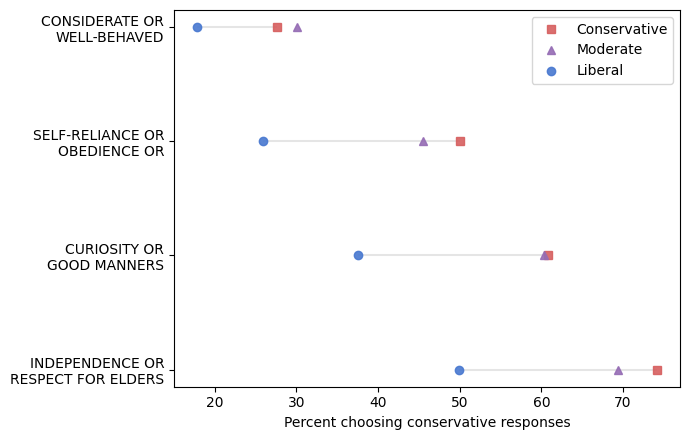

In [119]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_color_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")

In [120]:
from scipy.special import logit

ds = -logit(questions.mean().values)
ds

array([-0.58204013, -0.17557325,  0.28149422,  1.0043515 ])

In [121]:
from scipy.special import expit

es = np.linspace(-6, 6, 21)
E, D = np.meshgrid(es, ds)
P = expit(E - D)
Q = 1 - P
ns = P.sum(axis=0)

In [122]:
from scipy.stats import norm
from empiricaldist import Pmf

ps = norm.pdf(es, 0, 4)
prior = Pmf(ps, es)
prior.normalize()

1.4751408263256967

In [123]:
n, m = questions.shape
size = n, m, len(es)
res = np.empty(size)

In [124]:
a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [125]:
product = res.prod(axis=1) * prior.values
posterior = product / product.sum(axis=1)[:, None]
con = (posterior * ns).sum(axis=1)
con.shape

(52908,)

In [126]:
answered = questions.notna().sum(axis=1)
(answered >= 3).mean()

0.49690027973085354

In [127]:
recent["conservatism"] = pd.Series(con, recent.index)
recent.loc[answered < 3, "conservatism"] = np.nan
recent["conservatism"].describe()

/tmp/ipykernel_202514/3702985926.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  recent["conservatism"] = pd.Series(con, recent.index)
/tmp/ipykernel_202514/3702985926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["conservatism"] = pd.Series(con, recent.index)


count    26290.000000
mean         1.899714
std          1.217248
min          0.311246
25%          0.311246
50%          1.992556
75%          2.906396
max          3.670388
Name: conservatism, dtype: float64

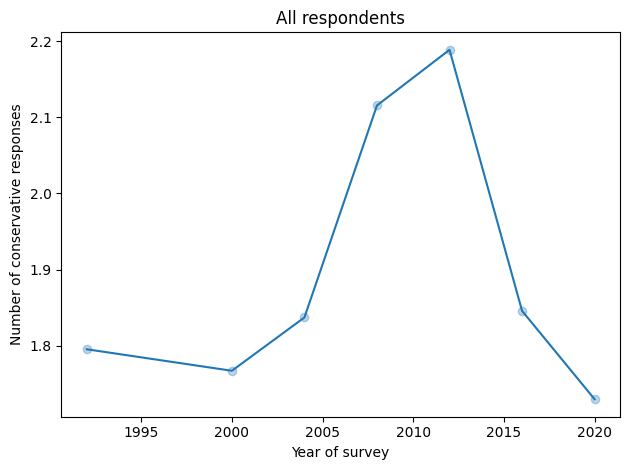

In [130]:
series = recent.groupby("year")["conservatism"].mean()

plot_series_lowess(series, frac=0.3, color="C0", label="")
decorate(xlabel="Year of survey", 
         ylabel="Number of conservative responses",
         title='All respondents')

In [131]:
recent['sex'].value_counts()

sex
2.0    29010
1.0    23779
0.0      108
3.0       11
Name: count, dtype: int64

In [132]:
table = recent.pivot_table(index="year", columns="sex", values="conservatism", aggfunc='mean')

In [133]:
columns = [1, 2]
color_map = dict(zip(columns, ['C0', 'C1']))
label_map = dict(zip(columns, ['Male', 'Female']))

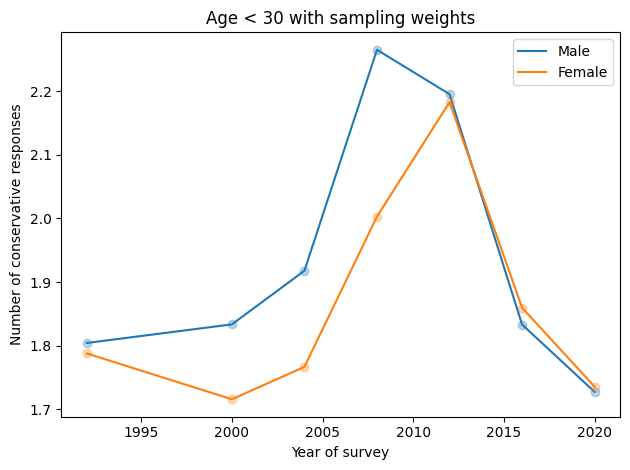

In [134]:
for column in columns:
    plot_series_lowess(table[column], color=color_map[column], label=label_map[column])

decorate(xlabel="Year of survey", 
         ylabel="Number of conservative responses",
         title='All respondents')